In [1]:
ls

Aggregation.txt              animation.gif             R15.txt
Aggregation.txt12frames.gif  animation.mp4             R15.txt22frames.gif
Aggregation.txt20frames.gif  Compound.txt              README.md
Aggregation.txt22frames.gif  Compound.txt22frames.gif  spiral20frames.mp4
Aggregation.txt3frames.gif   D31.txt                   spiral40frames.mp4
animation-400.mp4            jain40frames.mp4          spiral.txt
animation-b.mp4              jain.txt                  spiral.txt20frames.gif
animation-c.mp4              jain.txt20frames.gif      spiral.txt5frames.gif
animation-d.mp4              pogo.ipynb


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [41]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [6]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [7]:
filename = 'D31.txt'
data = np.loadtxt(filename)
y = data[:,2]
print(y.shape)
X = data[:,:2]
print(X.shape)

(3100,)
(3100, 2)


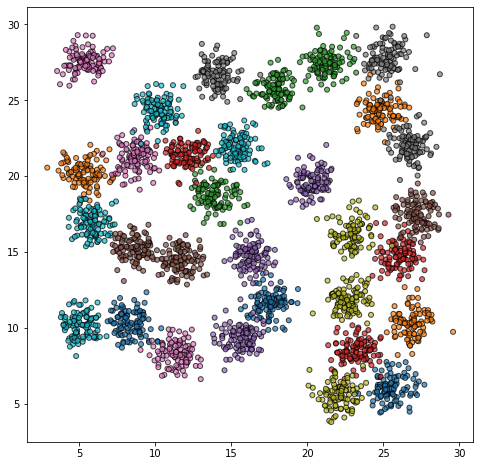

In [8]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [9]:
rips_complex = gudhi.RipsComplex(points=X,max_edge_length=.5)


In [10]:

simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)


#for i in simplex_tree.get_filtration():
#    print(i)
    
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())


3100 vertices
19194 simplices
dimension: 1


In [11]:
diag = simplex_tree.persistence()

In [12]:
#simplex_tree.prune_above_filtration(.9)

usetex mode requires TeX.


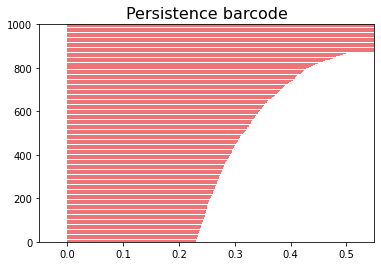

In [13]:
gudhi.plot_persistence_barcode(diag)
plt.show()

In [14]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []

for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:    
        if all(value != 0 for value in list(point_dict.values())):
            print('break')
            print(simplex)
            break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())


In [15]:
len(cluster_dict_list)

16094

In [16]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [17]:
df = df[:len(cluster_dict_list)]
df

simplex  distance
0               [0]  0.000000
1               [1]  0.000000
2               [2]  0.000000
3               [3]  0.000000
4               [4]  0.000000
...             ...       ...
16089    [815, 819]  0.446277
16090  [1740, 1745]  0.446295
16091    [918, 921]  0.446324
16092    [443, 453]  0.446348
16093    [142, 166]  0.446378

[16094 rows x 2 columns]

In [18]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [19]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [20]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [21]:
sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / sum

In [22]:
#sum(df.loc[:,'probability_vector'])

In [23]:
df.nlargest( 60,['gaps'])

simplex  distance      gaps  normed_distance  normed_gaps  \
3109  [2817, 2839]  0.013800  0.003514         0.030916     0.000109   
3107  [2125, 2155]  0.009758  0.002485         0.021861     0.000054   
3100  [1831, 1894]  0.002300  0.002300         0.005153     0.000012   
3106  [1011, 1070]  0.007273  0.002130         0.016294     0.000035   
3104      [72, 78]  0.004600  0.001347         0.010305     0.000014   
3128    [318, 366]  0.023000  0.001302         0.051526     0.000067   
3204    [924, 980]  0.040950  0.001246         0.091739     0.000114   
3122  [1630, 1686]  0.017964  0.001219         0.040243     0.000049   
3186  [1531, 1574]  0.037086  0.001159         0.083083     0.000096   
3125  [3063, 3092]  0.019651  0.001108         0.044024     0.000049   
3148    [209, 215]  0.027981  0.001060         0.062684     0.000066   
3126  [1820, 1894]  0.020700  0.001049         0.046373     0.000049   
3127    [592, 594]  0.021698  0.000998         0.048609     0.000049   
3101    [232, 279]  0.003253  0.000953         0.007287     0.000007   
3120  [2960, 2995]  0.016263  0.000835         0.036434     0.000030   
3287  [2230, 2283]  0.054525  0.000831         0.122150     0.000102   
3168    [822, 871]  0.033489  0.000799         0.075023     0.000060   
3233  [2580, 2590]  0.045188  0.000767         0.101232     0.000078   
3655  [3076, 3097]  0.090726  0.000761         0.203250     0.000155   
3134    [512, 588]  0.024772  0.000759         0.055495     0.000042   
3161    [800, 822]  0.032035  0.000752         0.071767     0.000054   
3199  [2676, 2688]  0.039302  0.000747         0.088047     0.000066   
3441  [2741, 2799]  0.071300  0.000746         0.159730     0.000119   
3118  [1567, 1595]  0.015429  0.000702         0.034565     0.000024   
3147  [1033, 1047]  0.026921  0.000697         0.060309     0.000042   
3256  [1507, 1554]  0.050233  0.000689         0.112534     0.000078   
3182  [1021, 1048]  0.035706  0.000673         0.079990     0.000054   
3294  [1043, 1053]  0.055296  0.000625         0.123877     0.000077   
3132  [2740, 2799]  0.023680  0.000565         0.053049     0.000030   
3468  [1682, 1688]  0.075200  0.000565         0.168467     0.000095   
3113  [2402, 2421]  0.014546  0.000556         0.032588     0.000018   
3105    [839, 877]  0.005143  0.000543         0.011522     0.000006   
3155  [1531, 1562]  0.029988  0.000534         0.067182     0.000036   
3108  [1736, 1737]  0.010286  0.000528         0.023043     0.000012   
3236    [624, 642]  0.045827  0.000522         0.102665     0.000054   
4218    [140, 197]  0.128347  0.000516         0.287531     0.000148   
3248  [1421, 1440]  0.048355  0.000495         0.108327     0.000054   
3369    [843, 897]  0.064400  0.000495         0.144272     0.000071   
3196  [2946, 2992]  0.038555  0.000483         0.086373     0.000042   
3121  [2302, 2387]  0.016744  0.000481         0.037511     0.000018   
3558  [2015, 2016]  0.082928  0.000480         0.185779     0.000089   
3388    [733, 758]  0.066700  0.000478         0.149425     0.000071   
3348  [1555, 1566]  0.061715  0.000473         0.138258     0.000065   
3951    [319, 366]  0.112135  0.000473         0.251212     0.000119   
3170  [2045, 2716]  0.033959  0.000471         0.076077     0.000036   
3364  [2701, 2713]  0.063615  0.000459         0.142513     0.000065   
3153  [1204, 1297]  0.029274  0.000455         0.065582     0.000030   
3692  [2105, 2176]  0.094300  0.000450         0.211256     0.000095   
3633    [508, 511]  0.088513  0.000449         0.198291     0.000089   
3639  [1507, 1547]  0.089316  0.000445         0.200090     0.000089   
3247    [365, 395]  0.047860  0.000444         0.107218     0.000048   
3327    [324, 351]  0.059800  0.000444         0.133967     0.000059   
3457    [500, 570]  0.072623  0.000438         0.162694     0.000071   
3123  [1820, 1831]  0.018400  0.000436         0.041221     0.000018   
3157    [637, 648]  0.030686  0.000434         0.06

In [24]:
df.nlargest( 40,['probability_vector'])

simplex  distance      gaps  normed_distance  normed_gaps  \
14192  [1407, 1416]  0.412105  0.000225         0.923219     0.000207   
10256  [2715, 2782]  0.330128  0.000256         0.739571     0.000190   
13318  [3011, 3087]  0.395500  0.000214         0.886020     0.000190   
15161    [809, 885]  0.429952  0.000197         0.963203     0.000190   
15029    [317, 324]  0.427534  0.000192         0.957785     0.000184   
14983  [1400, 1466]  0.426450  0.000180         0.955357     0.000172   
14103  [2139, 2183]  0.410413  0.000180         0.919430     0.000166   
5630     [360, 372]  0.191288  0.000374         0.428533     0.000160   
15760  [2525, 2552]  0.440761  0.000162         0.987416     0.000160   
3655   [3076, 3097]  0.090726  0.000761         0.203250     0.000155   
11225    [432, 479]  0.350959  0.000196         0.786238     0.000154   
4218     [140, 197]  0.128347  0.000516         0.287531     0.000148   
6152   [2647, 2650]  0.211425  0.000313         0.473646     0.000148   
9987     [809, 894]  0.324047  0.000204         0.725948     0.000148   
11439    [337, 389]  0.355854  0.000186         0.797203     0.000148   
13552  [1570, 1593]  0.400022  0.000165         0.896150     0.000148   
14315  [1766, 1775]  0.414473  0.000160         0.928524     0.000148   
7068   [2622, 2665]  0.241325  0.000263         0.540629     0.000142   
8755   [1022, 1091]  0.292109  0.000217         0.654399     0.000142   
9347   [1787, 1790]  0.307358  0.000207         0.688560     0.000142   
9847   [1120, 1158]  0.320625  0.000198         0.718282     0.000142   
13280    [465, 470]  0.394596  0.000161         0.883995     0.000142   
13346  [2817, 2870]  0.395927  0.000160         0.886978     0.000142   
14053    [335, 393]  0.409381  0.000155         0.917117     0.000142   
14992  [2301, 2342]  0.426698  0.000149         0.955912     0.000142   
5056   [2727, 2735]  0.168450  0.000362         0.377372     0.000136   
6985   [2172, 2181]  0.238502  0.000255         0.534306     0.000136   
8124     [428, 441]  0.274163  0.000222         0.614196     0.000136   
9204     [558, 563]  0.304027  0.000200         0.681097     0.000136   
10115  [2401, 2436]  0.326576  0.000186         0.731613     0.000136   
10171  [1206, 1252]  0.327804  0.000186         0.734366     0.000136   
10619    [703, 725]  0.338600  0.000180         0.758551     0.000136   
10758  [2370, 2373]  0.341517  0.000178         0.765085     0.000136   
11295  [2923, 2969]  0.352613  0.000173         0.789944     0.000136   
15208  [3046, 3085]  0.430985  0.000141         0.965515     0.000136   
4534   [2635, 2669]  0.144003  0.000405         0.322603     0.000131   
8157     [106, 133]  0.275482  0.000211         0.617150     0.000130   
12417  [1921, 1929]  0.376919  0.000154         0.844396     0.000130   
13139  [1701, 1786]  0.391676  0.000149         0.877454     0.000130   
16016  [1945, 1951]  0.445037  0.000131         0.996995     0.000130   

       probability_vector  
14192            0.000929  
10256            0.000849  
13318            0.000849  
15161            0.000849  
15029            0.000823  
14983            0.000770  
14103            0.000743  
5630             0.000717  
15760            0.000717  
3655             0.000693  
11225            0.000690  
4218             0.000665  
6152             0.000664  
9987             0.000664  
11439            0.000664  
13552            0.000664  
14315            0.000664  
7068             0.000637  
8755             0.000637  
9347             0.000637  
9847             0.000637  
13280            0.000637  
13346            0.000637  
14053            0.000637  
14992            0.000637  
5056             0.000611  
6985             0.000611  
8124             0.000611  
9204             0.000611  
10115            0.000610  
10171            0.000610  
10619            0.000610  
10758            0.000610  
11295            0.000610  
15208            0.000610  
4534      

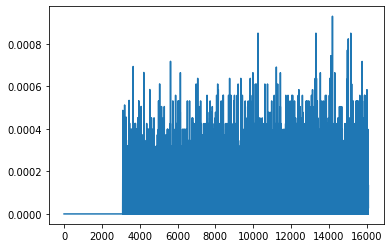

In [25]:
plt.plot(df['probability_vector'])

In [26]:
idx = int(df.nlargest( 1,['probability_vector']).index.values)
idx

14192

In [27]:
candidates = list(df.nlargest( 20,['probability_vector']).index)

In [28]:
candidates.append(len(df)-1)
candidates.append(0)

In [29]:
candidates.sort()
candidates

[0,
 3655,
 4218,
 5630,
 6152,
 7068,
 8755,
 9347,
 9987,
 10256,
 11225,
 11439,
 13318,
 13552,
 14103,
 14192,
 14315,
 14983,
 15029,
 15161,
 15760,
 16093]

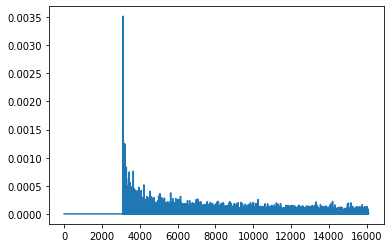

In [30]:
plt.plot(df['gaps'])

In [42]:
metrics.silhouette_score(X, pred, metric="euclidean")

0.010288215887804727

%%time
length = len(cluster_dict_list)-1
silhouette_scores = []

for i in range(length):
    pred = np.array(list(cluster_dict_list[i].values()))
    silhouette_scores.append(metrics.silhouette_score(X, pred, metric="euclidean"))

In [49]:
silhouette_list = []
for i in candidates:
    silhouette = metrics.silhouette_score(X,     np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

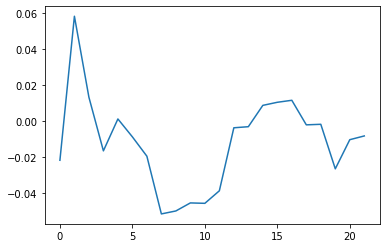

In [50]:
plt.plot(silhouette_list)

In [51]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [53]:
idx = len(df)-1
idx

16093

In [65]:
np.array(list(cluster_dict_list[idx].values()))

array([  5,   0,   5, ...,   3,   3, 909])

In [66]:

print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

your dataset appears to have 129 clusters


In [67]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.6820628200215841
-0.08072710260319309


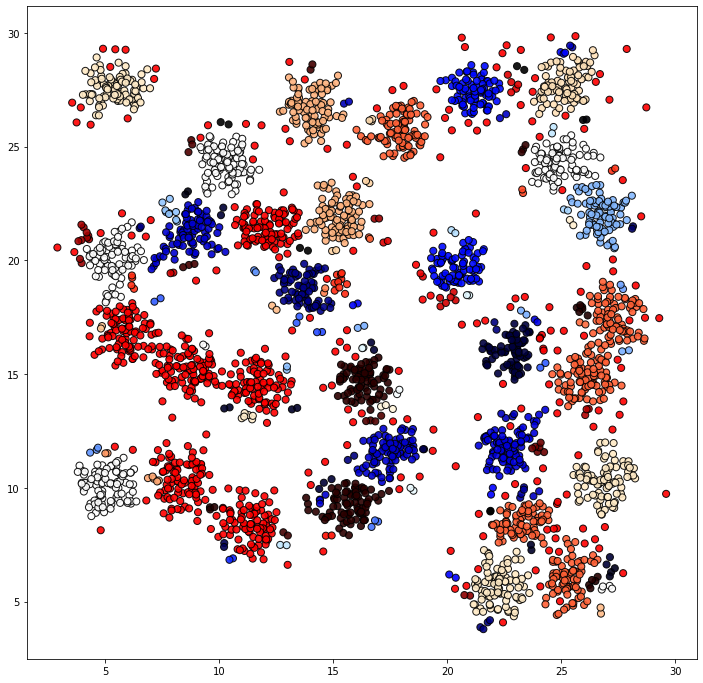

In [68]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

<ipython-input-59-988b76476ec6>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


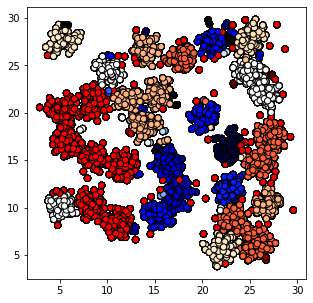

In [59]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(candidates)


outfile = filename + str(frames) + 'frames.gif'

if os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap='rainbow',
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[candidates[i]].values())),
                    marker="o",
                    cmap='flag',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=1000,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


In [60]:
rand_score_list = []
true = y
for i in range(len(cluster_dict_list)):
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

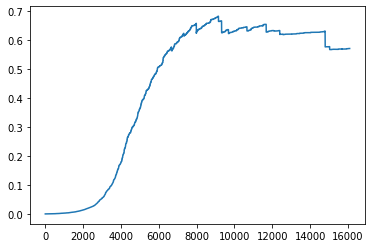

In [61]:
 plt.plot(rand_score_list)

In [62]:
max(rand_score_list)

0.6820628200215841

In [63]:
rand_score_list.index(max(rand_score_list))

9137

In [64]:
idx = rand_score_list.index(max(rand_score_list))
print(idx)

9137


ValueError: 'tab10b' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [ ]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


In [ ]:
cluster_dict_list, candidates, idx = pogo(X)

In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


In [ ]:
%matplotlib notebook

In [ ]:
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[0].values())),
                marker="o",
                cmap='gist_rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
ax.set(xlim=(-1, 35), ylim=(-1, 35))

def animate(n):
    scatter.set_array(np.array(list(cluster_dict_list[n*interval].values())))
    
ani = FuncAnimation(fig, animate,interval=20,frames=frames,repeat=True, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

ani.save('animation-d.mp4', writer=writer, dpi=250)


fig.show()

In [ ]:
dataset = np.loadtxt('D31.txt')

X, y = dataset[:, :2],dataset[:, 2]

size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")